In [1]:
import os
import re
import subprocess
import xtgeo
import pandas as pd
from xtgeo.grid3d import GridProperty
import numpy as np
%matplotlib inline
import tkinter as tk
from tkinter import messagebox
from tkinter import filedialog


# Функция для выполнения метода 2.5D

In [2]:
def run_simulation():
    number = find_data_file()
        
    insert_blocks(f"C:/Simulation_block/Block/FULL_TNAV__{number}.DATA", "arithmetic_blocks.txt", number)
    
    GRIDFILE   = f"C:/Simulation_block/Block/FULL_TNAV__{number}_GRID.EGRID"        # ACTNUM уже сидит тут
    PERMFILE   = f"C:/Simulation_block/Block/FULL_TNAV__{number}_PROP_PERMX.GRDECL"
    

    # Читаем сам грид (геометрию каркаса)
    grd = xtgeo.grid_from_file(GRIDFILE)
    
    # get actnum
    #actnum = grd.get_actnum()

    # читаем куб проницаемости
    prop = "PERMX"
    permx_i = xtgeo.gridproperty_from_file(PERMFILE, name=prop, grid=grd, fformat='grdecl')

    # добавляем к нашему гриду
    grd.append_prop(permx_i)

    # весь грид выгружаем в датафрейм
    dataframe = grd.get_dataframe(activeonly=False)

    # используется специальная функция для чтения карт
    new_map = xtgeo.surface_from_file('C:/Simulation_block/np4_fusion_gis_gdis_seismic_not_decreased_surface', fformat='irap_ascii')

    new_map.get_dataframe(activeonly=False)
    try:
        new_map.get_value_from_xy(point=(x,y))
    except:
        permx_map = GridProperty(ncol=permx_i.ncol, nrow=permx_i.nrow, nlay=permx_i.nlay)
        permx_map.name = 'MAP_PERMX'
        df_temp = dataframe[dataframe['KZ']==1]
        permx_map.values = 0
        for i,j,x,y in zip(df_temp.IX,df_temp.JY,df_temp.X_UTME,df_temp.Y_UTMN):
            perm_from_map = new_map.get_value_from_xy(point=(x,y), sampling='bilinear')
            permx_map.values[i-1,j-1,0:grd.nlay] = perm_from_map
        # проверяем как прочиталась карта
        new_map.quickplot()
        # Простой метод - бегаем по первому слою грида (именно структурному слою)
        # вытаскиваем координаты центров ячеек грида
        # по координатам читаем значения с карты
        # значения запивыем во все слои с данными индексами I,J

        permx_map = GridProperty(ncol=permx_i.ncol, nrow=permx_i.nrow, nlay=permx_i.nlay)
        permx_map.name = 'PERMX'
        df_temp = dataframe[dataframe['KZ']==1]
        permx_map.values = 0
        for i,j,x,y in zip(df_temp.IX,df_temp.JY,df_temp.X_UTME,df_temp.Y_UTMN):
            perm_from_map = new_map.get_value_from_xy(point=(x,y), sampling='bilinear')
            permx_map.values[i-1,j-1,0:grd.nlay] = perm_from_map
    
        permx_map.values[np.isnan(permx_map.values)] = 100
        permx_map.to_file(f'C:\Simulation_block\Block\FULL_TNAV__{number}_PROP_PERMX.GRDECL', fformat="grdecl",dtype=np.float32,fmt='%8.2f')

        # запускаем модель на рассчет через командную строку
        subprocess.run([f'C:\Simulation_block\Block.bat', number])


# Функция для выполнения метода ГСР

In [3]:
def run_gsr():
    number = find_data_file()
    GRIDFILE   = f"C:/Simulation_block/Block/FULL_TNAV__{number}_GRID.EGRID"        # ACTNUM уже сидит тут
    PERMFILE   = f"C:/Simulation_block/Block/FULL_TNAV__{number}_PROP_PERMX.GRDECL"

    # Читаем сам грид (геометрию каркаса)
    grd = xtgeo.grid_from_file(GRIDFILE)

    # get actnum
    #actnum = grd.get_actnum()

    # читаем куб проницаемости
    prop = "PERMX"
    permx_i = xtgeo.gridproperty_from_file(PERMFILE, name=prop, grid=grd, fformat='grdecl')

    # добавляем к нашему гриду
    grd.append_prop(permx_i)

    # весь грид выгружаем в датафрейм
    dataframe = grd.get_dataframe(activeonly=False)

    # используется специальная функция для чтения карт
    new_map = xtgeo.surface_from_file('np4_fusion_gis_gdis_seismic_not_decreased_surface', fformat='irap_ascii') 
    # проверяем как прочиталась карта
    new_map.quickplot()

    # Простой метод - бегаем по первому слою грида (именно структурному слою)
    # вытаскиваем координаты центров ячеек грида
    # по координатам читаем значения с карты
    # значения запивыем во все слои с данными индексами I,J

    permx_map = GridProperty(ncol=permx_i.ncol, nrow=permx_i.nrow, nlay=permx_i.nlay)
    permx_map.name = prop
    df_temp = dataframe[dataframe['KZ']==1]
    permx_map.values = 0
    for i,j,x,y in zip(df_temp.IX,df_temp.JY,df_temp.X_UTME,df_temp.Y_UTMN):
        perm_from_map = new_map.get_value_from_xy(point=(x,y), sampling='bilinear')
        permx_map.values[i-1,j-1,0:grd.nlay] = perm_from_map
    
    permx_map.values[np.isnan(permx_map.values)] = 0
    permx_map.to_file('PERMX_from_map.GRDECL', fformat="grdecl",dtype=np.float32,fmt='%8.2f')
    
    # Записываем 2.5Д грид с поправкой на ГСР
    df_gsr_perm = pd.read_excel('gsr_perm_from_model.xlsx')
    df_gsr_poro = pd.read_excel('gsr_poro_from_model.xlsx')

    # Простой метод - бегаем по первому слою грида (именно структурному слою)
    # и вытаскиваем координаты центров ячеек грида perm_from_map,
    # по координатам читаем значения с карты.
    # Загружаем ГСР (df_gsr) и вычисляем среднее значение gsr_av.
    # Находим множитель mult = perm_from_map / gsr_av.
    # Запивыем во все слои значение mult*df_gsr

    permx_map = GridProperty(ncol=permx_i.ncol, nrow=permx_i.nrow, nlay=permx_i.nlay)
    permx_map.name = prop
    df_temp = dataframe[dataframe['KZ']==1]
    permx_map.values = 0
    gsr_av = df_gsr_perm['PERMX'].mean()
    for i,j,x,y in zip(df_temp.IX,df_temp.JY,df_temp.X_UTME,df_temp.Y_UTMN):
        perm_from_map = new_map.get_value_from_xy(point=(x,y), sampling='bilinear')
        if perm_from_map is None: perm_from_map = 0
        mult = perm_from_map / gsr_av
        for k,perm_gsr in zip(df_gsr_perm.KZ, df_gsr_perm.PERMX):
            permx_map.values[i-1,j-1,k-1] = mult*perm_gsr
    
    permx_map.values[np.isnan(permx_map.values)] = 0
    permx_map.to_file('PERMX_from_map_GSR.GRDECL', fformat="grdecl",dtype=np.float32,fmt='%8.2f')



    # Для пористости используем просто ГСР

    poro_gsr = GridProperty(ncol=permx_i.ncol, nrow=permx_i.nrow, nlay=permx_i.nlay)
    poro_gsr.name = 'PORO'
    df_temp = dataframe[dataframe['KZ']==1]
    for i,j in zip(df_temp.IX,df_temp.JY):
        for k,por_gsr in zip(df_gsr_poro.KZ,df_gsr_poro.PORO):
            poro_gsr.values[i-1,j-1,k-1] = por_gsr
    
    poro_gsr.to_file('PORO_GSR.GRDECL', fformat="grdecl",dtype=np.float32,fmt='%8.2f')

In [5]:
def find_data_file():
    folder_path = filedialog.askdirectory(title="Выберите папку с data файлом")
     # Функция для извлечения числа из имени файла
    def extract_number_from_filename(filename):
        match = re.search(r'FULL_TNAV__(\d+)\.DATA', filename)
        if match:
            return match.group(1)
        return None

    # Ищем файлы в папке
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.startswith("FULL_TNAV__") and filename.endswith(".DATA"):
                number = extract_number_from_filename(filename)
    return number


In [6]:
def on_button_click():
    selected_method = method_var.get()
    if selected_method == 1:
        app.destroy()
        run_simulation()
    elif selected_method == 2:
        run_gsr()
        app.destroy()

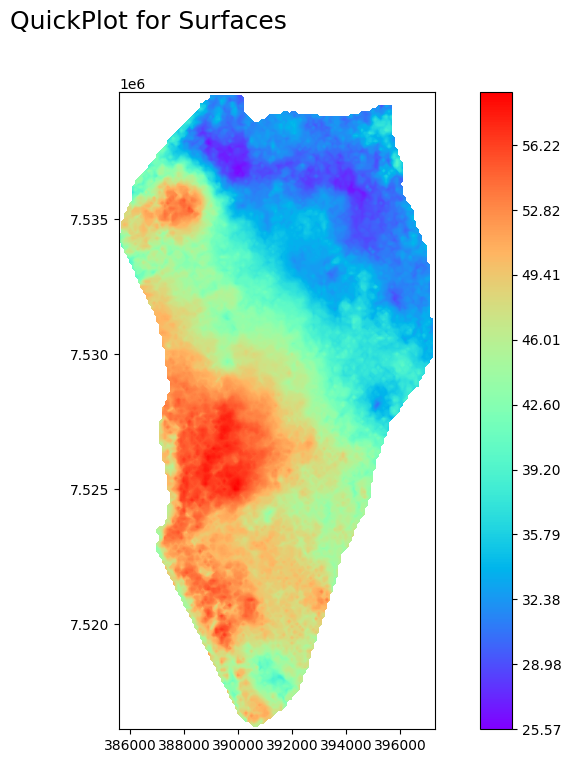

In [7]:
app = tk.Tk()
app.title("Выбор метода моделирования")

method_var = tk.IntVar()

method_label = tk.Label(app, text="Выберите метод моделирования:")
method_label.pack()

radio1 = tk.Radiobutton(app, text="Метод 2.5D", variable=method_var, value=1)
radio2 = tk.Radiobutton(app, text="Метод ГСР", variable=method_var, value=2)
radio1.pack()
radio2.pack()

start_button = tk.Button(app, text="Запустить моделирование", command=on_button_click)
start_button.pack()

app.mainloop()
